In [1]:
import os
import sys
import pandas as pd
import tensorflow as tf

# set warnings
import warnings
warnings.simplefilter(action='ignore', category = Warning)

# add parent folder path to the namespace
sys.path.append(os.path.dirname(os.getcwd()))

# import modules and components
from utils.data_assets import DataGenerator, TensorDataSet, PreProcessing
from utils.model_assets import ModelValidation, Inference
import utils.global_paths as globpt
import configurations as cnf

# specify relative paths from global paths and create subfolders
images_path = os.path.join(globpt.data_path, 'images')
cp_path = os.path.join(globpt.train_path, 'checkpoints')
os.mkdir(images_path) if not os.path.exists(images_path) else None
os.mkdir(cp_path) if not os.path.exists(cp_path) else None

# Load data and model

In [2]:
preprocessor = PreProcessing()
inference = Inference(cnf.seed) 

# load the model for inference and print summary
model, parameters = inference.load_pretrained_model(cp_path)
model_path = inference.folder_path
model.summary(expand_nested=True)

# load and reprocess data
filepath = os.path.join(model_path, 'preprocessing', 'train_data.csv')                
train_data = pd.read_csv(filepath, sep=';', encoding='utf-8')
filepath = os.path.join(model_path, 'preprocessing', 'test_data.csv')                
test_data = pd.read_csv(filepath, sep=';', encoding='utf-8')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
Model: "FEXT_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 fe_xt_encoder (FeXTEncoder)  (None, 8, 8, 512)        6542208   
                                                                 
 fe_xt_decoder (FeXTDecoder)  (None, 256, 256, 3)      7590211   
                                                                 
Total params: 14,132,419
Trainable params: 14,132,419
Non-trainable params: 0
_________________________________________________________________


## Create generator and datasets

In [3]:
# regenerate paths
train_data = preprocessor.dataset_from_images(images_path, dataset=train_data)
test_data = preprocessor.dataset_from_images(images_path, dataset=test_data)

# initialize the images generator for the train and test data, and create the 
# tf.dataset according to batch shapes
train_generator = DataGenerator(train_data, 20, cnf.picture_shape, 
                                augmentation=False, shuffle=True)
test_generator = DataGenerator(test_data, 20, cnf.picture_shape, 
                               augmentation=False, shuffle=True)

# initialize the TensorDataSet class with the generator instances
# create the tf.datasets using the previously initialized generators 
datamaker = TensorDataSet()
train_dataset = datamaker.create_tf_dataset(train_generator)
test_dataset = datamaker.create_tf_dataset(test_generator)

# Model evaluation

### Evaluation of loss and metrics

In [4]:
validator = ModelValidation(model)

# create subfolder for evaluation data
#------------------------------------------------------------------------------
eval_path = os.path.join(model_path, 'evaluation') 
os.mkdir(eval_path) if not os.path.exists(eval_path) else None

# evluate the model on both the train and test dataset
#------------------------------------------------------------------------------
train_eval = model.evaluate(train_dataset, batch_size=20, verbose=1)
test_eval = model.evaluate(test_dataset, batch_size=20, verbose=1)

print(f'''
-------------------------------------------------------------------------------
MODEL EVALUATION
-------------------------------------------------------------------------------    
Train dataset:
- Loss:   {train_eval[0]}
- Metric: {train_eval[1]} 

Test dataset:
- Loss:   {test_eval[0]}
- Metric: {test_eval[1]}        
''')

10/10 [==============================] - 2s 237ms/step - loss: 0.0733 - cosine_similarity: 0.9643

-------------------------------------------------------------------------------
MODEL EVALUATION
-------------------------------------------------------------------------------    
Train dataset:
- Loss:   0.07574135810136795
- Metric: 0.9627060294151306 

Test dataset:
- Loss:   0.07329370826482773
- Metric: 0.964307427406311        



### Visual inspection

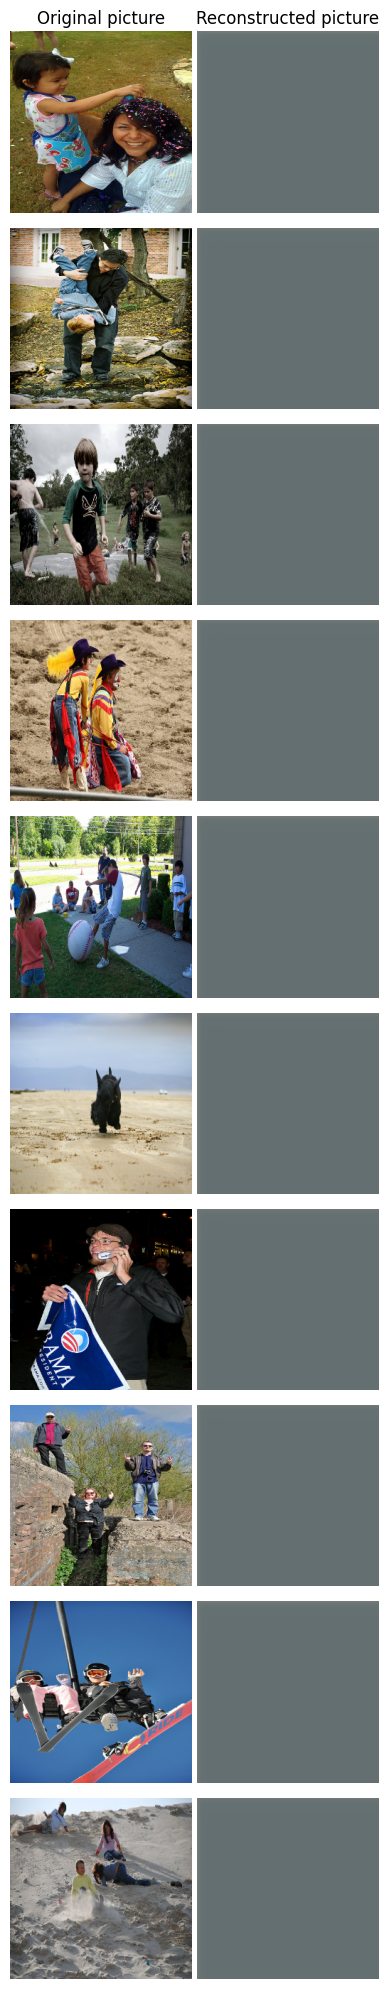

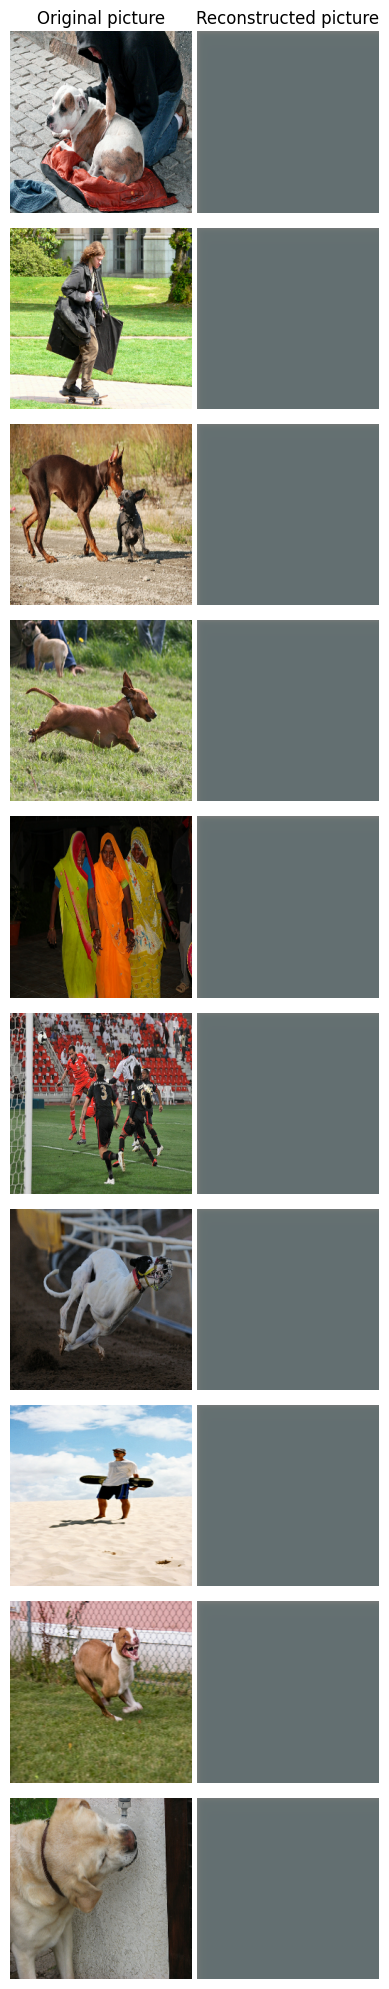

In [5]:
# perform visual validation for the train dataset (initialize a validation tf.dataset
# with batch size of 10 images)
validation_batch = train_dataset.unbatch().batch(10).take(1)
for images, labels in validation_batch:
    recostructed_images = model.predict(images, verbose=0)
    validator.visual_validation(images, recostructed_images, 'visual_validation_train', eval_path)

# perform visual validation for the test dataset (initialize a validation tf.dataset
# with batch size of 10 images)
validation_batch = test_dataset.unbatch().batch(10).take(1)
for images, labels in validation_batch:
    recostructed_images = model.predict(images, verbose=0) 
    validator.visual_validation(images, recostructed_images, 'visual_validation_test', eval_path)